In [1]:
%load_ext autoreload
%autoreload 2

# Estimating Pi Using the Monte Carlo Method

In [2]:
%%writefile pi.py


from random import uniform

def estimate_total_in_circle(n_samples):
    total_in_circle = 0
    for step in range(int(n_samples)):
        x = uniform(0, 1)
        y = uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        total_in_circle += is_in_unit_circle
        
    return total_in_circle

def calc_pi(list_total_in_circle, n_samples):
    return sum(list_total_in_circle) * 4 / n_samples


Overwriting pi.py


In [3]:
n_times = 3
n_samples = 1e7

In [4]:
from pi import calc_pi, estimate_total_in_circle

calc_pi((estimate_total_in_circle(n_samples), ), n_samples)

3.1424724

In [5]:
import timeit

time = timeit.Timer("calc_pi((estimate_total_in_circle({}), ), {})".format(n_samples, n_samples),
                    "from pi import calc_pi, estimate_total_in_circle")
time.timeit(n_times) / n_times

5.513518258000356

# Use multiprocessing for run in parallel

In [6]:
%%writefile -a pi.py


from multiprocessing import Pool


def parallel_calc_pi(n_jobs, n_samples):
    # get residual
    residual = n_samples % n_jobs
    # get number of samples per worker
    n_samples_per_worker = (n_samples - residual) / n_jobs
    n_samples_per_process = (n_samples_per_worker, ) * n_jobs
    # apply residual for first worker
    n_samples_per_process = (n_samples_per_process[0] + residual, ) + n_samples_per_process[1:]
    
    # create pool of executors and calc it
    with Pool(processes=n_jobs) as p:
        list_total_in_circle = p.map(estimate_total_in_circle, n_samples_per_process)
        
    value = calc_pi(list_total_in_circle, n_samples)
    return value


Appending to pi.py


In [7]:
from pi import parallel_calc_pi

parallel_calc_pi(n_jobs=1, n_samples=n_samples)

3.1422132

# Practically the same performance as without multiprocessing

In [8]:
import timeit

time = timeit.Timer("parallel_calc_pi(n_jobs={}, n_samples={})".format(1, n_samples),
                    "from pi import parallel_calc_pi")
time.timeit(n_times) / n_times

5.646778676666145

# What number of processes is optimal

My computer have 4 phisical cores and 8 threads

In [9]:
!grep 'cpu cores' /proc/cpuinfo | uniq

cpu cores	: 4


In [10]:
!echo "CPU threads: $(grep -c processor /proc/cpuinfo)"

CPU threads: 8


In [11]:
from multiprocessing import cpu_count

cpu_count()

8

# Calculate performance depends of number process

In [12]:
import tqdm
import timeit
from multiprocessing import cpu_count

results = {}
for i in tqdm.tqdm(range(1, cpu_count() + 1)):
    time = timeit.Timer("parallel_calc_pi(n_jobs={}, n_samples={})".format(i, n_samples),
                        "from pi import parallel_calc_pi")
    results[i] = time.timeit(n_times) / n_times


100%|██████████| 8/8 [00:57<00:00,  7.25s/it]


In [13]:
import pandas as pd

df = pd.Series(results).to_frame()
df.reset_index(inplace=True)
df.columns = ['number of process', 'time, s']
df['versus one'] = df.loc[0]['time, s'] / df['time, s']
df['parallel loss'] = 1 - df['versus one'] / df['number of process']
df['number of process'] = df['number of process'].astype(str)
df = df.round(4)
df.head().T

,0,1,2,3,4
number of process,1,2,3,4,5
"time, s",5.6134,2.948,2.0172,1.5536,1.8912
versus one,1,1.9041,2.7828,3.6132,2.9682
parallel loss,0,0.0479,0.0724,0.0967,0.4064


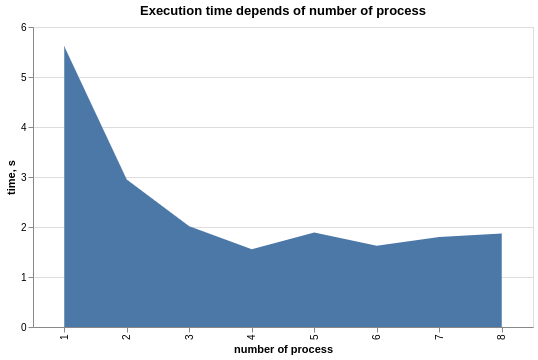

In [14]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='time, s'
).properties(
    title='Execution time depends of number of process',
    width=500,
    height=300
)

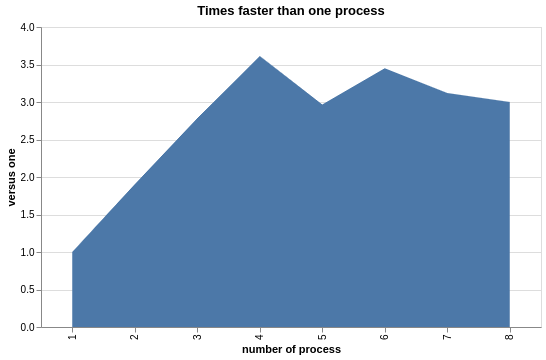

In [15]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='versus one'
).properties(
    title='Times faster than one process',
    width=500,
    height=300
)

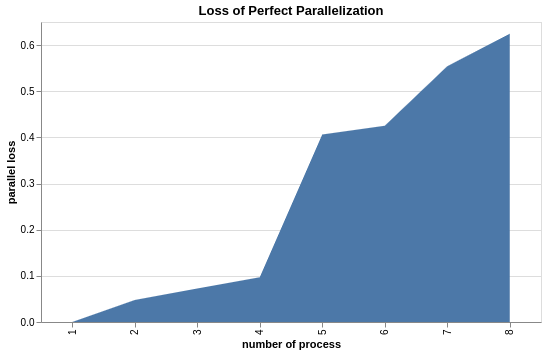

In [16]:
import altair as alt

alt.Chart(df).mark_area().encode(
    x='number of process',
    y='parallel loss'
).properties(
    title='Loss of Perfect Parallelization',
    width=500,
    height=300
)

# Conclusion

- optimal value of process equal to number phisical cores
- performance grows linearly (~10% loss of ideal parallelization) up to the number of physical processors